# 安徽安庆市项目`WRF-CMAQ`模拟分析
## Spatial Distribution : `chem-obs data`

---
*@author: Evan*\
*@date: 2023-03-29*

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

## 读取数据

In [3]:
chemFile=xr.open_dataset('F:/Data/case_anqing/compressed_chem.nc')
metFile=xr.open_dataset('F:/Data/case_anqing/compressed_met.nc')

In [4]:
lat=chemFile.latitude
lon=chemFile.longitude

O3_L1=np.squeeze(chemFile.O3.sel(level=1000,method='nearest'))
O3_L2=np.squeeze(chemFile.O3.sel(level=850,method='nearest'))

uw_L1=np.squeeze(metFile.uwind.sel(level=1000,method='nearest'))
vw_L1=np.squeeze(metFile.vwind.sel(level=1000,method='nearest'))

uw_L2=np.squeeze(metFile.uwind.sel(level=850,method='nearest'))
vw_L2=np.squeeze(metFile.vwind.sel(level=850,method='nearest'))

print('lat & lon = ',lat.shape)
print('chem      = ',O3_L1.shape)

lat & lon =  (138, 135)
chem      =  (672, 138, 135)


In [5]:
# calculate MDA8 O3
mda8_L1 = O3_L1.rolling(time=8).mean().resample({'time':'D'}).max(dim='time')
mda8_L2 = O3_L2.rolling(time=8).mean().resample({'time':'D'}).max(dim='time')

In [6]:
# calculate average uv wind
uuL1 = uw_L1.resample({'time':'D'}).mean(dim='time')
vvL1 = vw_L1.resample({'time':'D'}).mean(dim='time')

uuL2 = uw_L2.resample({'time':'D'}).mean(dim='time')
vvL2 = vw_L2.resample({'time':'D'}).mean(dim='time')

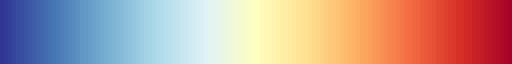

In [10]:
import cmaps

colormap = cmaps.MPL_RdYlBu_r
colormap

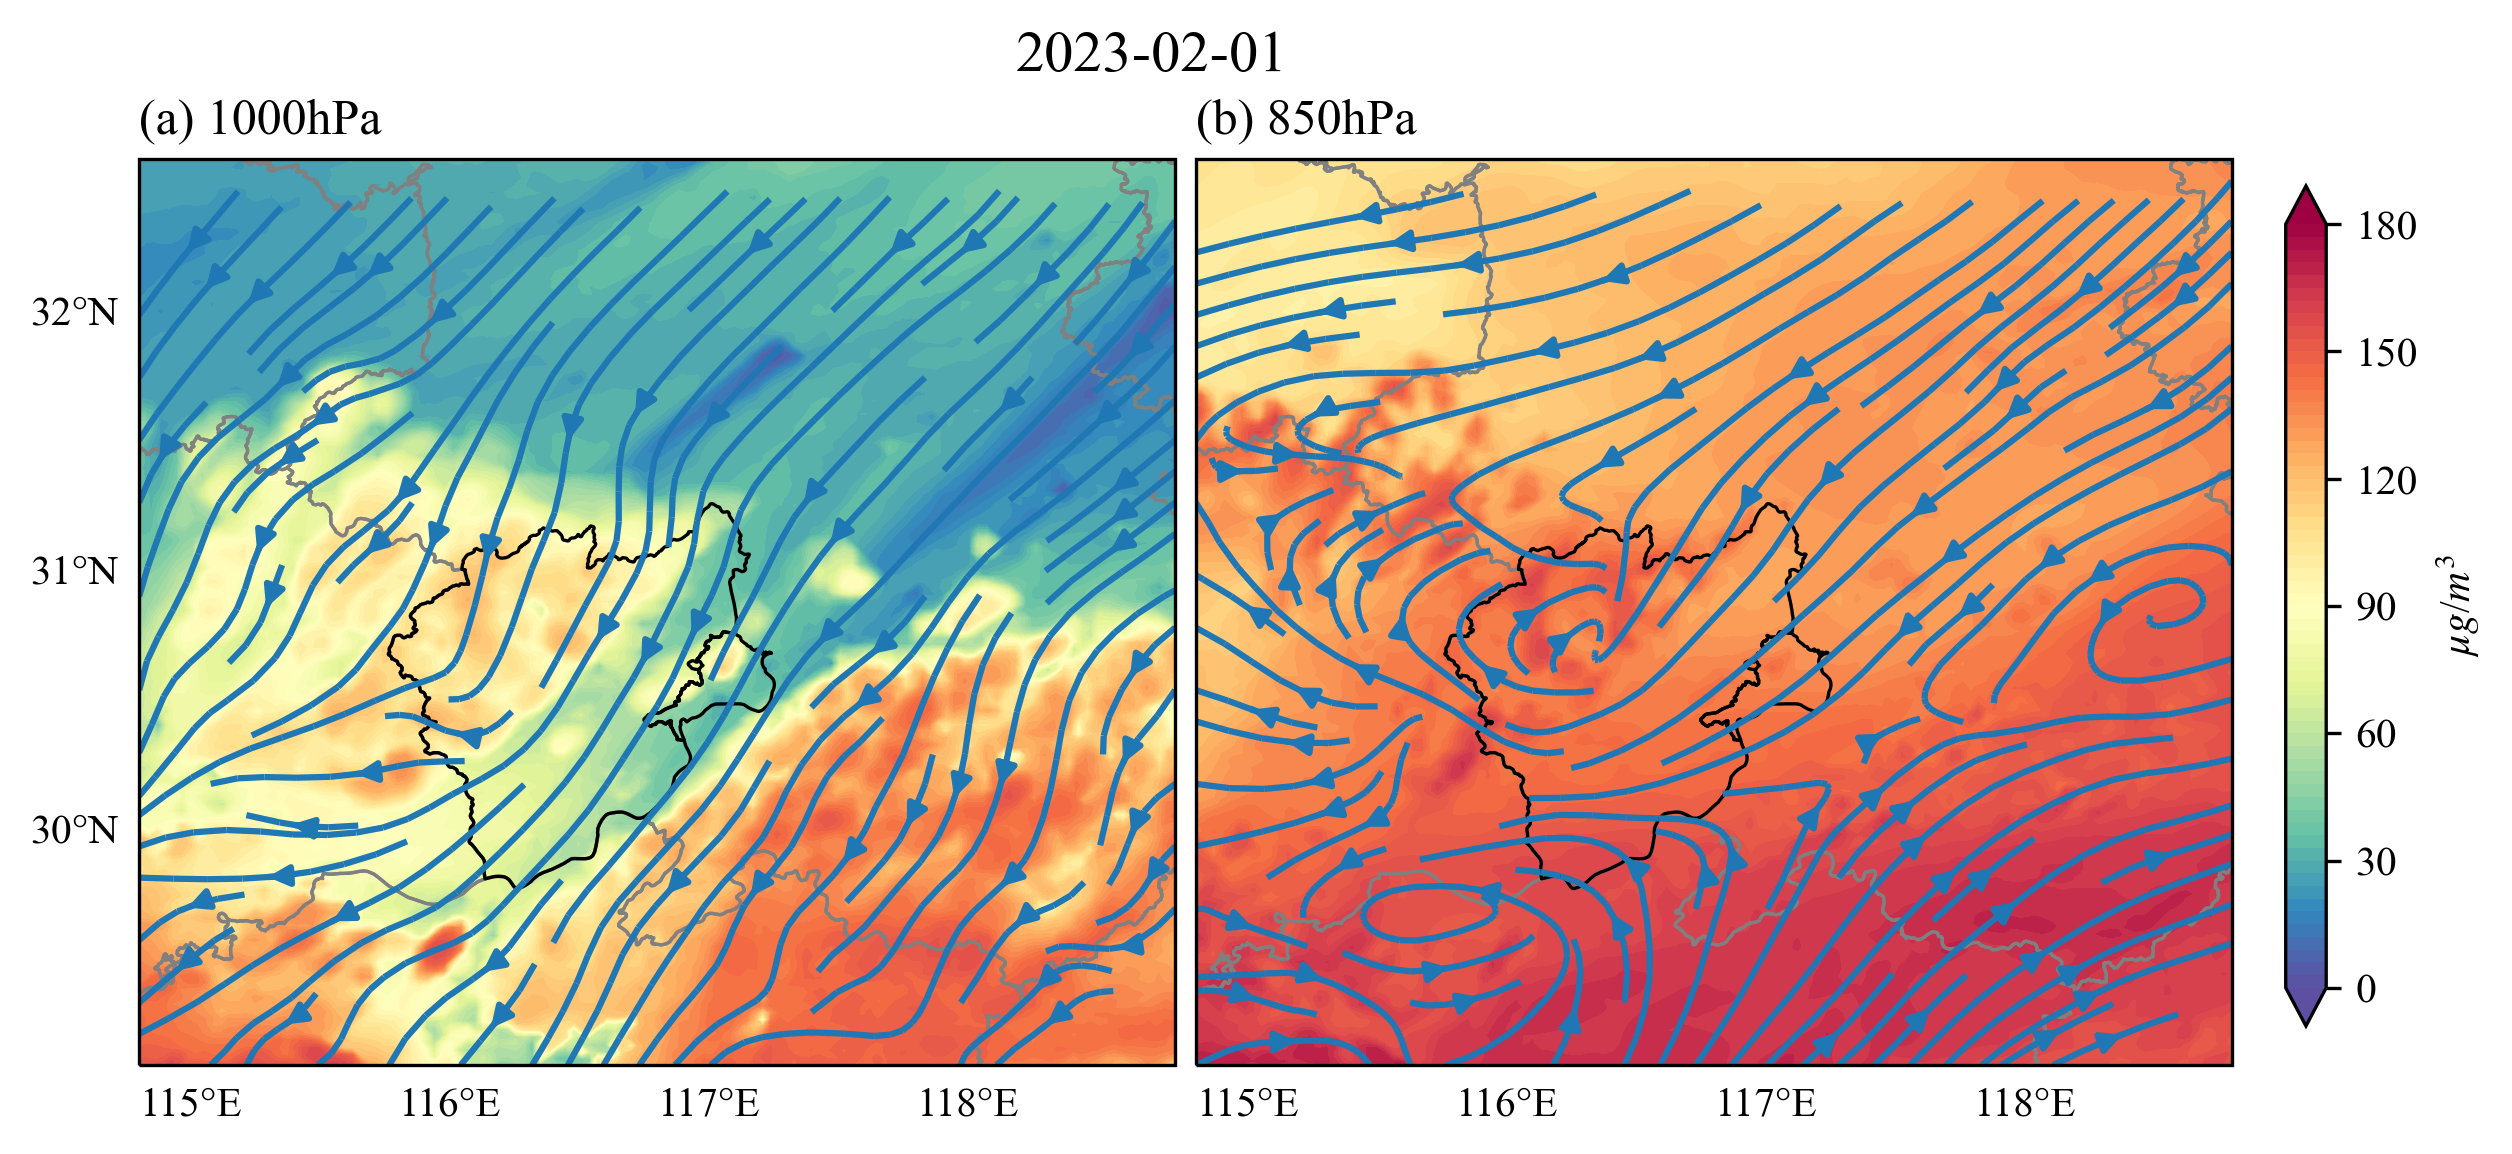

In [30]:
date=1
cmax=181
cmaplevel=np.arange(0,cmax,3)
proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

shp_urban = Reader('F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp')
shp_rural = Reader('F:/Data/case_anqing/shapefile/Anqing_rural/rural.shp')
shp_pro = Reader('F:/shapefile/shp_for_ArcGis/ChinaAdminDivisonSHP-master/2. Province/province.shp')
for i in range(2):
    ax[i].add_feature(cfeat.ShapelyFeature(shp_pro.geometries(),proj,edgecolor='gray',facecolor='None'), linewidth=0.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_urban.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)
    ax[i].add_feature(cfeat.ShapelyFeature(shp_rural.geometries(),proj,edgecolor='k',facecolor='None'), linewidth=0.8)

    gl=ax[i].gridlines(
        xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
        draw_labels=True, x_inline=False, y_inline=False,
        linewidth=0, linestyle='--', color='gray')
    gl.top_labels = False
    gl.right_labels =False
    gl.rotate_labels=False
    
    ax[i].set_extent([114.8, 118.8, 29.1, 32.6],ccrs.PlateCarree()) # d03
#     ax[i].set_extent([115.6, 117.4, 29.7, 31.4],ccrs.PlateCarree()) # anqing

    if i>0:
        gl.left_labels=False

xgrid = np.size(uuL1,2)
ygrid = np.size(vvL1,1)
ngrid = 10

# contour map
cmap=ax[0].contourf(lon,lat,mda8_L1[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')
cmap=ax[1].contourf(lon,lat,mda8_L2[date-1,:,:],transform=proj,cmap='Spectral_r',levels=cmaplevel,extend='both')

# wind quiver
# ax[0].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
#         uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
#         transform=proj,color='k',alpha=1,scale=150,headwidth=3)
# ax[1].quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
#         uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid],
#         transform=proj,color='k',alpha=1,scale=150,headwidth=3)

ax[0].streamplot(lon[0:ygrid:ngrid,0:xgrid:ngrid].values,lat[0:ygrid:ngrid,0:xgrid:ngrid].values,
        uuL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,vvL1[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,
        transform=proj,cmap=plt.cm.Spectral)
ax[1].streamplot(lon[0:ygrid:ngrid,0:xgrid:ngrid].values,lat[0:ygrid:ngrid,0:xgrid:ngrid].values,
        uuL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,vvL2[date-1,0:ygrid:ngrid,0:xgrid:ngrid].values,
        transform=proj,cmap=plt.cm.Spectral)

# share colorbar
fig.subplots_adjust(right=0.9,wspace=0.02)
position= fig.add_axes([0.92,0.15,0.015,0.7])
cbar=fig.colorbar(cmap,cax=position)
cbar.set_ticks(np.arange(0,cmax+1,30))
cbar.set_label('$\mu$$g$/$m^3$')

ax[0].set_title('(a) 1000hPa',loc='left')
ax[1].set_title('(b) 850hPa',loc='left')
plt.suptitle(pd.to_datetime('2023-02-'+str(date)).strftime('%Y-%m-%d'),size=14)

plt.show()